# OpenClip

[OpenClip](https://github.com/mlfoundations/open_clip/tree/main) is an source implementation of OpenAI's CLIP.

These multi-modal embeddings can be used to embed images or text.

In [ ]:
%pip install --upgrade --quiet  langchain-experimental

In [ ]:
%pip install --upgrade --quiet  pillow open_clip_torch torch matplotlib

We can the list of available CLIP embedding models and checkpoints:

In [ ]:
import open_clip

open_clip.list_pretrained()

Below, I test a larger but more performant model based on the table ([here](https://github.com/mlfoundations/open_clip)):
```
model_name = "ViT-g-14"
checkpoint = "laion2b_s34b_b88k"
```

But, you can also opt for a smaller, less performant model:
```
model_name = "ViT-B-32"
checkpoint = "laion2b_s34b_b79k"
```

The model `model_name`,`checkpoint`  are set in `langchain_experimental.open_clip.py`.

For text, use the same method `embed_documents` as with other embedding models.

For images, use `embed_image` and simply pass a list of uris for the images.

In [3]:
import numpy as np
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from PIL import Image

# Image URIs
uri_dog = "/Users/rlm/Desktop/test/dog.jpg"
uri_house = "/Users/rlm/Desktop/test/house.jpg"

# Embe images or text
clip_embd = OpenCLIPEmbeddings(model_name="ViT-g-14", checkpoint="laion2b_s34b_b88k")
img_feat_dog = clip_embd.embed_image([uri_dog])
img_feat_house = clip_embd.embed_image([uri_house])
text_feat_dog = clip_embd.embed_documents(["dog"])
text_feat_house = clip_embd.embed_documents(["house"])

## Sanity Check

Let's reproduce results shown in the OpenClip Colab [here](https://colab.research.google.com/github/mlfoundations/open_clip/blob/master/docs/Interacting_with_open_clip.ipynb#scrollTo=tMc1AXzBlhzm).

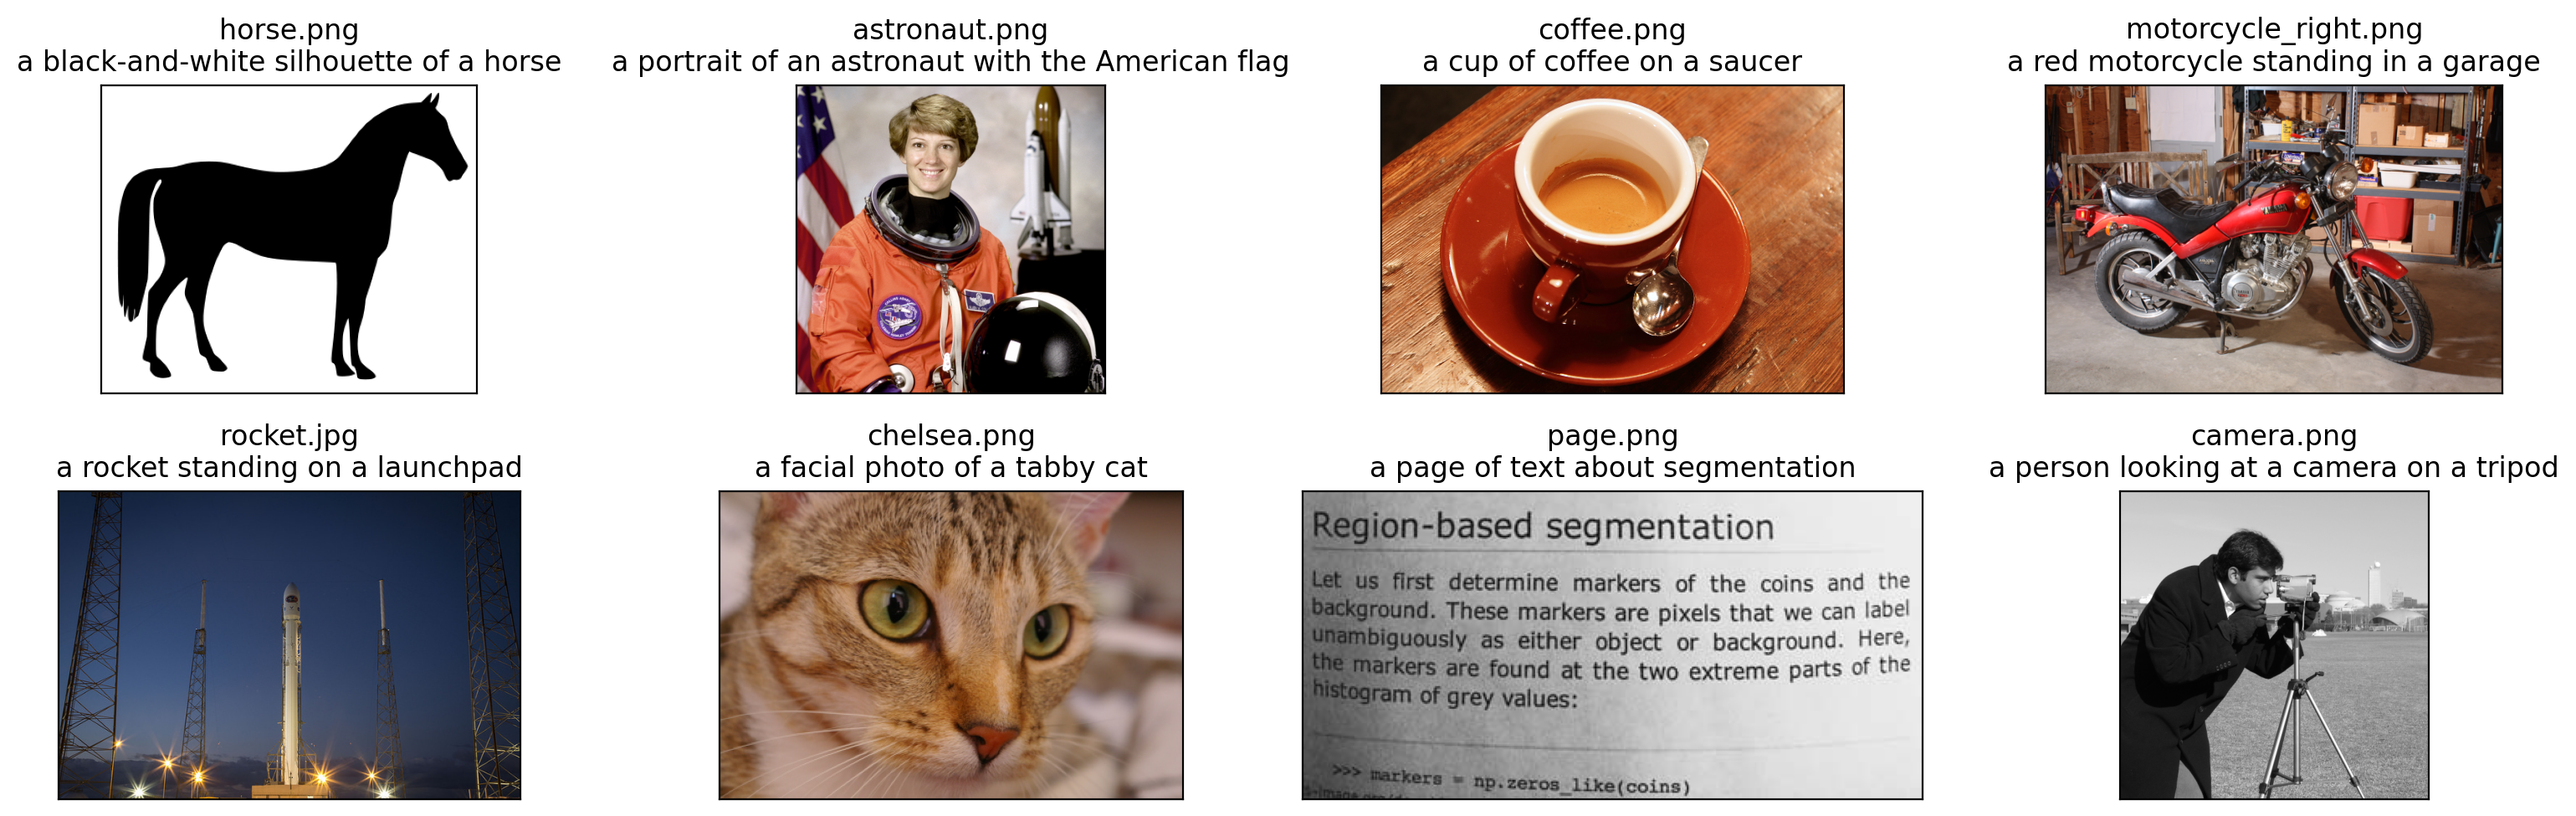

In [8]:
import os
from collections import OrderedDict

import IPython.display
import matplotlib.pyplot as plt
import skimage

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer",
}

original_images = []
images = []
image_uris = []  # List to store image URIs
texts = []
plt.figure(figsize=(16, 5))

# Loop to display and prepare images and assemble URIs
for filename in [
    filename
    for filename in os.listdir(skimage.data_dir)
    if filename.endswith(".png") or filename.endswith(".jpg")
]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image_path = os.path.join(skimage.data_dir, filename)
    image = Image.open(image_path).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(image)  # Origional code does preprocessing here
    texts.append(descriptions[name])
    image_uris.append(image_path)  # Add the image URI to the list

plt.tight_layout()

Text(0.5, 1.0, 'Cosine similarity between text and image features')

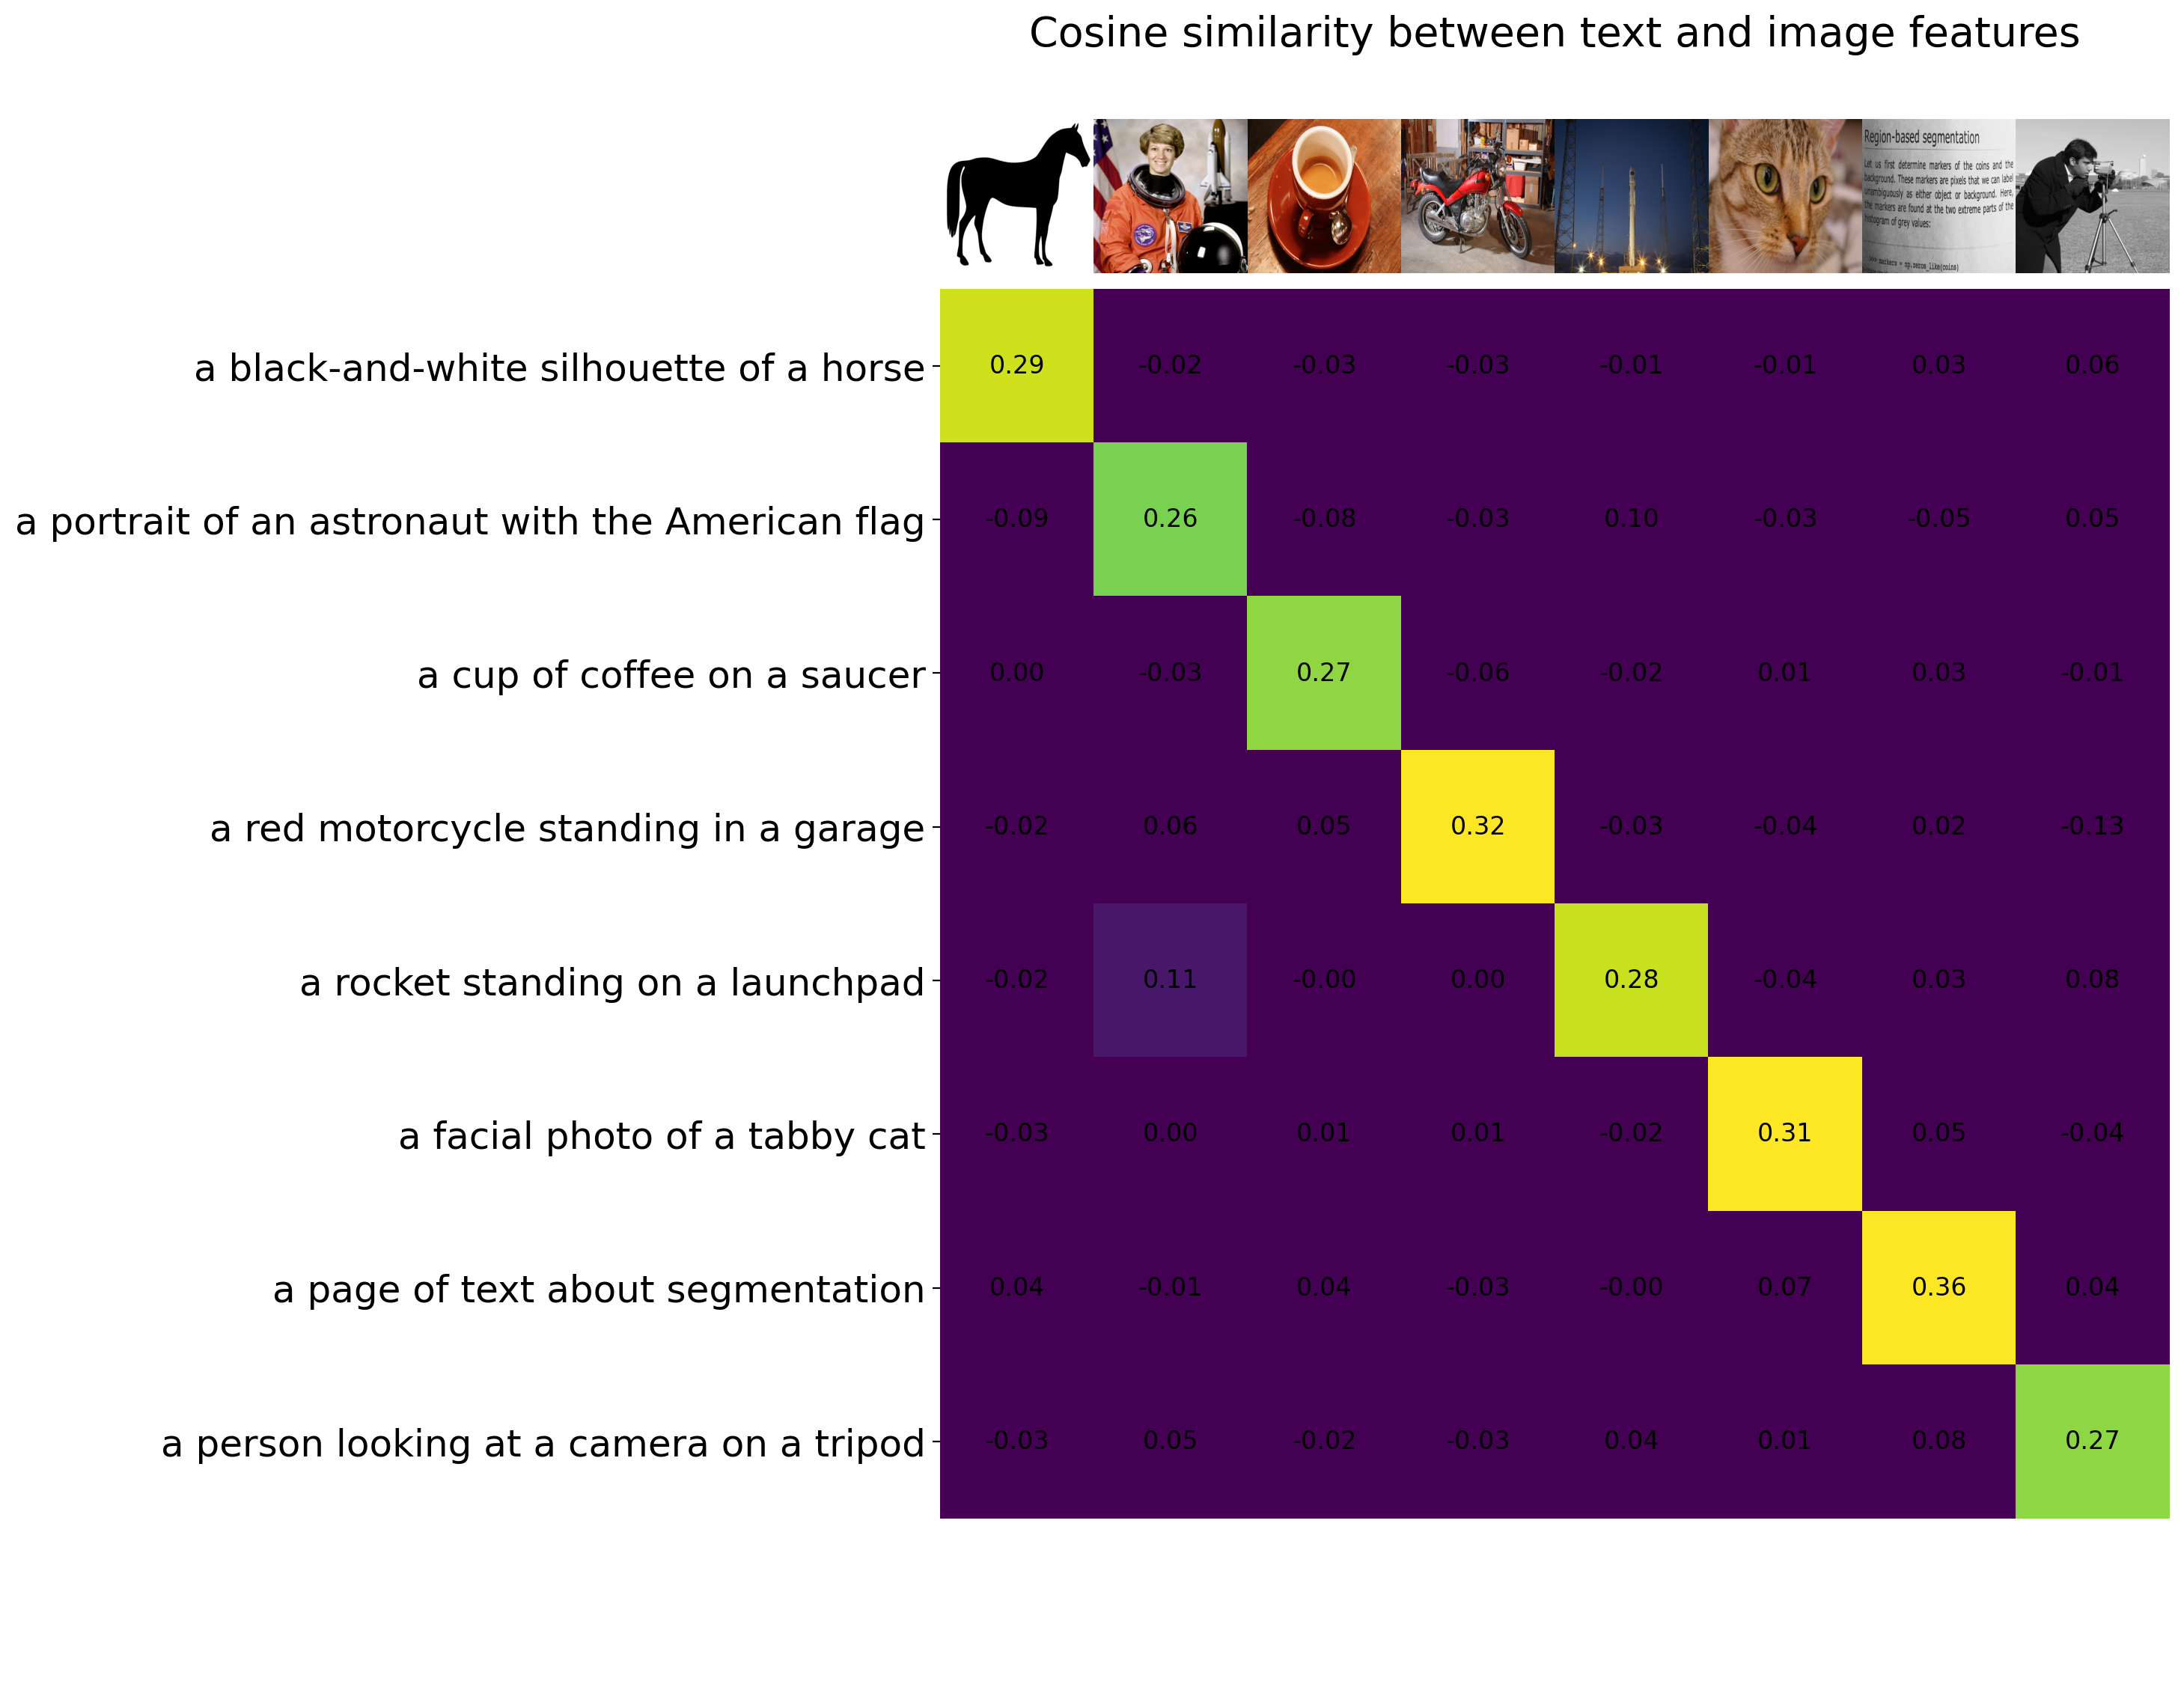

In [9]:
# Instantiate your model
clip_embd = OpenCLIPEmbeddings()

# Embed images and text
img_features = clip_embd.embed_image(image_uris)
text_features = clip_embd.embed_documents(["This is " + desc for desc in texts])

# Convert the list of lists to numpy arrays for matrix operations
img_features_np = np.array(img_features)
text_features_np = np.array(text_features)

# Calculate similarity
similarity = np.matmul(text_features_np, img_features_np.T)

# Plot
count = len(descriptions)
plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)